Importing Necessary Libraries

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pyautogui
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output, Image, display
from io import BytesIO
import PIL.Image

#Models

##head position

In [ ]:
def pre_processing_head_position(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    image = np.array(image)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

In [ ]:
# Load the saved model.
model = tf.keras.models.load_model("most_updated_head_position_prediction.h5")

##vertical gaze

In [ ]:
def pre_processing_vertical_position(image_path, minBox):
    image = cv2.imread(image_path)
    # print("image")
    # plt.imshow(image)
    # plt.axis('off')
    # plt.show()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # print("gray")
    # plt.imshow(gray)
    # plt.axis('off')
    # plt.show()
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(minBox, minBox))

    if len(faces) == 1:
        print('one face found') # Require exactly one face for processing

        # Extract the the face region using coordinates
        x, y, w, h = faces[0]
        face_image = image[y:y+h, x:x+w]

        # Convert the face image back to RGB format
        face_image_rgb = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)

        # Resize and normalize the image
        resized_image = cv2.resize(face_image_rgb, (171, 76))
        normalized_image = resized_image / 255.0


        # Add batch dimension
        image = np.expand_dims(normalized_image, axis=0)

        return image
    else:
        print(len(faces))
        print('No face found or multiple faces detected.')
        return None

In [ ]:
model2 = tf.keras.models.load_model("most_updated_vertical_position_prediction.h5")

##horizontal gaze

In [ ]:
def pre_processing_horizontal_position(image_path, minBox):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(minBox, minBox))

    if len(faces) == 1:
        print('one face found') # Require exactly one face for processing

        # Extract the coordinates of the face region
        x, y, w, h = faces[0]
        face_image = image[y:y+h, x:x+w]

        # Convert the face image back to RGB format
        face_image_rgb = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)

        # Resize and normalize the image
        resized_image = cv2.resize(face_image_rgb, (171, 76))
        normalized_image = resized_image / 255.0

        # Add batch dimension
        image = np.expand_dims(normalized_image, axis=0)

        return image
    else:
        print(len(faces))
        print('No face found or multiple faces detected.')
        return None

In [ ]:
model3 = tf.keras.models.load_model("most_updated_horizontal_position_prediction.h5")

##Mouse control

In [ ]:
#mouse adjusting functions:
def adjust_mouse_down():
    pyautogui.moveRel(0, 100, duration = 0.1)  # Move the mouse cursor down by 200 pixels

def adjust_mouse_up():
    pyautogui.moveRel(0, -100, duration=0.1)  # Move the mouse cursor up by 200 pixels

def adjust_mouse_right():
    pyautogui.moveRel(100, 0, duration=0.1)  # Move the mouse cursor right by 200 pixels

def adjust_mouse_left():
    pyautogui.moveRel(-100, 0, duration=0.1)  # Move the mouse cursor left by 200 pixels


#Video Capture

In [ ]:
def array_to_image(a, fmt='jpeg'):
    # Create binary stream object
    f = BytesIO()

    # Convert array to binary stream object
    PIL.Image.fromarray(a).save(f, fmt)

    return Image(data=f.getvalue())

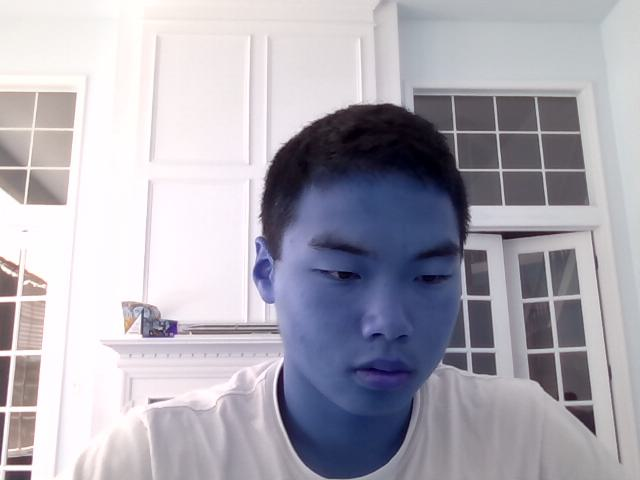

1/1 [==============================] - 1s 1s/step
one face found


In [ ]:
cap = cv2.VideoCapture(0)

tick = 0

#video loop, snapshot per 0.5 seconds
while True:
    try:
        # Capture and save image
        ret, frame = cap.read()
        #cv2.imshow('Video Stream', frame)
        image_path = 'head_image.jpg'
        cv2.imwrite(image_path, frame)


        ##preprocess image and run through model:
        head_position_prediction = np.argmax(model.predict(pre_processing_head_position(image_path)))
        vertical_prediction = np.argmax(model2.predict(pre_processing_vertical_position(image_path,100)))
        #horizontal_prediction = np.argmax(model3.predict(pre_processing_horizontal_position(image_path,100)))

        if head_position_prediction == 0 or head_position_prediction == 4:
            print("You are either tilting it left or right, please keep your head straight.")
        if head_position_prediction == 4:
            pyautogui.click(button='right')
        if head_position_prediction == 0:
            pyautogui.click()

        tick += 1
        left_right(tick)

        #for horizontal_prediction
        if (horizontal_prediction) == 0:
          #adjust_mouse_left()
          print("left")
        elif (horizontal_prediction) == 2:
          #adjust_mouse_right()
          print("right")

        #for vertical_prediction
        if (vertical_prediction) == 0: ##this is defined after one-hot encoding to human-understandable output
            adjust_mouse_down()
            print("down")
        elif (vertical_prediction) == 2:
            adjust_mouse_up()
            print("up")

        clear_output(wait=True)
        img = array_to_image(frame)
        display(img)

    except KeyboardInterrupt:
        # When everything done, release the capture
        cap.release()
        cv2.destroyAllWindows()
        break

#Debug & Tinker Terroritory

##Display boxed face

In [ ]:
#load and show original image from Video Capture section
image = cv2.imread("head_image.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

#Rectangle around faces
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(100, 100))
print(f"length of faces: {len(faces)} \nfaces list: {faces}")

#Draw rectangles on image
for (x, y, w, h) in faces:
    cv2.rectangle(image_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(image_with_rectangles)
plt.axis('off')
plt.show()
